# Liquidity Risk and Expected Stock Returns (Pastor Stambaugh 2003)
*Replication study by Eric Vorkink and Andrew Williams*

*We will proceed in the following manner*

1. Replicate the data/measures in the sample that they use
2. Replicate main results/tables (not all tables will be replicated)
3. Test their measures and results moving forward

**Replicating Data/Measures in sample** 

In [308]:
## Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tools.tools as sm
import statsmodels.regression.linear_model as stats
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
## Reading in our liquidity measure that we created
## WE NEED TO ADD IN THE CODE THAT WE USED TO CREATE THIS
liq=pd.read_feather('liq_data_updated.feather')
liq['vals']=liq['vals']*1000000
liq

,index,vals
0,10192610006,1.191493e-03
1,10192610022,1.342261e-02
2,10192610030,4.944852e-02
3,10192610049,-3.803185e-02
4,10192610057,NaN
...,...,...
3549131,9202293425,-2.938097e-04
3549132,9202293426,-5.287389e-03
3549133,9202293427,4.332515e-05
3549134,9202293429,-1.978194e-05


In [3]:
# Reading in monthly stock data from CRSP
#path = r"C:\\Users\ericv\Downloads\06-mstk_62-22 (1).csv"
path=r"crsp_monthly.csv"
df=pd.read_csv(path,parse_dates=['caldt'])
df

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,-4.37500,NaN,1771.0,3680.0,1.0
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,-3.25000,-0.257143,828.0,3680.0,1.0
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,-4.43750,0.365385,1078.0,3680.0,1.0
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,-4.00000,-0.098592,957.0,3793.0,1.0
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,-3.10938,-0.222656,1074.0,3793.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4776837,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.61000,-0.072489,7322220.0,3133470.0,1.0
4776838,93436,2022-09-30,88160R10,TSLA,11,3,9999,265.25000,-0.037589,12965500.0,3158000.0,1.0
4776839,93436,2022-10-31,88160R10,TSLA,11,3,9999,227.54000,-0.142168,17325800.0,3157750.0,1.0
4776840,93436,2022-11-30,88160R10,TSLA,11,3,9999,194.70000,-0.144326,18824200.0,3157750.0,1.0


In [4]:
# We want all dates to be the last day of the month
df['caldt']=df['caldt'] + pd.offsets.MonthEnd(0) 

In [5]:
## Some date cleaning of our liquidity measure table - this will allow us a proper merge with CRSP data
liq['datepermno']=pd.to_numeric(liq['index'])
liq['permno']=pd.to_numeric(liq['datepermno'].astype(str).str[-5:])
liq['caldt']=pd.to_numeric(liq['datepermno'].astype(str).str[:-5])
liq['newdate']=liq['caldt'].astype(str).str[:-4] + '-' + liq['caldt'].astype(str).str[-4:]
liq['caldt']=pd.to_datetime(liq['caldt'])

In [6]:
liq['caldt']=pd.to_datetime(liq['newdate'])
liq['caldt']=liq['caldt'] + pd.offsets.MonthEnd(0) 

In [7]:
liq=liq.drop(['index','datepermno','newdate'],axis=1)

In [8]:
liq=liq.sort_values(['permno','caldt']).reset_index(drop=True)

In [9]:
## Merge month-stock liquidity measure with CRSP monthly data
df=df.merge(liq,on=['permno','caldt'])
df

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,5.330482e-01
1,10001,1986-10-31,39040610,GFGC,11,3,4920,6.625,0.039216,362.0,991.0,3.0,4.991615e-02
2,10001,1986-11-30,39040610,GFGC,11,3,4920,7.000,0.056604,312.0,991.0,3.0,-1.580374e-01
3,10001,1986-12-31,39040610,GFGC,11,3,4920,7.000,0.015000,312.0,991.0,3.0,-1.390274e+00
4,10001,1987-01-31,39040610,GFGC,11,3,4920,6.750,-0.035714,399.0,991.0,3.0,-7.518338e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534897,93436,2022-05-31,88160R10,TSLA,11,3,9999,758.260,-0.129197,6470840.0,1036010.0,3.0,-5.279940e-07
3534898,93436,2022-06-30,88160R10,TSLA,11,3,9999,673.420,-0.111888,6684630.0,1041000.0,3.0,2.189319e-07
3534899,93436,2022-07-31,88160R10,TSLA,11,3,9999,891.450,0.323765,5800690.0,1044490.0,3.0,3.855547e-08
3534900,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.610,-0.072489,7322220.0,3133470.0,1.0,-2.491951e-07


In [10]:
## Create company value column
df['stock_val']=df['prc']*df['shr']

In [11]:
## Restrict sample to Aug 1962 and beyond using dfrep
dfrep=df.query("caldt>='1962-07-01'").reset_index(drop=True)

In [12]:
## Lag company value
dfrep.dropna()
dfrep['stock_val_lag']=dfrep.groupby('permno')['stock_val'].shift(1)

In [13]:
## Create the avg monthly liquidity across the sample. This is the gamma-hat sub t measure in the paper
monthdf=dfrep.groupby('caldt')['vals'].mean().to_frame()
monthdf

,vals
caldt,
1962-07-31,-0.046902
1962-08-31,0.011638
1962-09-30,-0.053053
1962-10-31,-0.244977
1962-11-30,-0.065033
...,...
2022-05-31,0.000915
2022-06-30,0.000635
2022-07-31,-0.000872


In [14]:
## Add in the scaling factor mt from the paper, it is the sum of lagged company value for stocks used in vals at time t
monthdf['mt']=dfrep.groupby('caldt')['stock_val_lag'].sum()
monthdf=monthdf.query("caldt>='1962-08-01'")
monthdf

,vals,mt
caldt,,
1962-08-31,0.011638,3.255810e+08
1962-09-30,-0.053053,3.235160e+08
1962-10-31,-0.244977,3.099985e+08
1962-11-30,-0.065033,3.141059e+08
1962-12-31,-0.051226,3.479098e+08
...,...,...
2022-05-31,0.000915,5.218094e+10
2022-06-30,0.000635,5.256506e+10
2022-07-31,-0.000872,4.938732e+10


In [15]:
## Scale m by m1 (keeps everything in 1962 dollars scale)
dfm1=dfrep.query("caldt >= '1962-08-27' and caldt<='1962-08-31'")
m1=dfm1['stock_val'].sum()
m1

323648015.4375

In [16]:
## m is now our scaling factor that will be used in a few places throughout the paper. It is at the month level.
monthdf['m']=monthdf['mt']/m1
monthdf

/tmp/ipykernel_90805/2153812727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthdf['m']=monthdf['mt']/m1


,vals,mt,m
caldt,,,
1962-08-31,0.011638,3.255810e+08,1.005972
1962-09-30,-0.053053,3.235160e+08,0.999592
1962-10-31,-0.244977,3.099985e+08,0.957826
1962-11-30,-0.065033,3.141059e+08,0.970517
1962-12-31,-0.051226,3.479098e+08,1.074963
...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443
2022-06-30,0.000635,5.256506e+10,162.414269
2022-07-31,-0.000872,4.938732e+10,152.595769


In [17]:
monthdf['vals'].describe()

count    722.000000
mean      -0.008216
std        0.021715
min       -0.244977
25%       -0.009322
50%       -0.001045
75%        0.000972
max        0.037045
Name: vals, dtype: float64

**Now that the data is ready, we will recreate some of the results from the paper:**
1. Figure 1
2. Table 2
3. Table 3
4. Table 4
5. Table 5
6. Table 7
7. Table 8

In [18]:
## Figure 1! Plotting val is the scaled liquidity measure that we will plot. We recreate their plot extremely well.
monthdf['plottingval']=monthdf['vals']*monthdf['m']
monthdf

/tmp/ipykernel_90805/3465182810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthdf['plottingval']=monthdf['vals']*monthdf['m']


,vals,mt,m,plottingval
caldt,,,,
1962-08-31,0.011638,3.255810e+08,1.005972,0.011707
1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031
1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645
1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116
1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066
...,...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443,0.147467
2022-06-30,0.000635,5.256506e+10,162.414269,0.103177
2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136


*Figure 1*

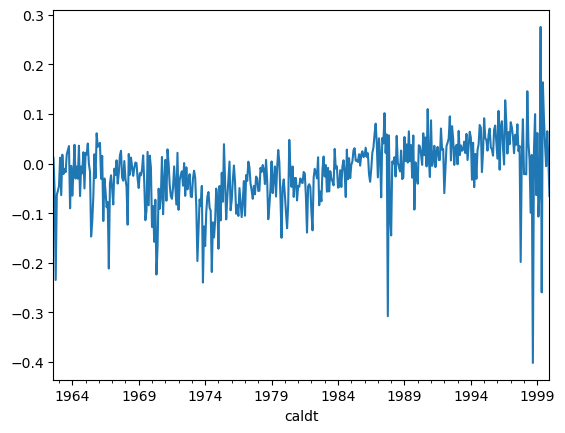

In [19]:
monthdf.loc['1962-01-01':'1999-12-31']['plottingval'].plot()
plt.show()

In [20]:
## We are now recreating the measure Lt - "The innovation in liquidity"
liq['lagvals']=liq.groupby('permno')['vals'].shift(1)

In [196]:
def get_avg_diff(x):
    diff = x.diff()
    return diff.mean()

In [21]:
liq['diff']=liq['vals']-liq['lagvals']
liq

,vals,permno,caldt,lagvals,diff
0,5.330482e-01,10001,1986-09-30,NaN,NaN
1,4.991615e-02,10001,1986-10-31,5.330482e-01,-4.831320e-01
2,-1.580374e-01,10001,1986-11-30,4.991615e-02,-2.079535e-01
3,-1.390274e+00,10001,1986-12-31,-1.580374e-01,-1.232237e+00
4,-7.518338e-02,10001,1987-01-31,-1.390274e+00,1.315091e+00
...,...,...,...,...,...
3549131,-5.279940e-07,93436,2022-05-31,NaN,NaN
3549132,2.189319e-07,93436,2022-06-30,-5.279940e-07,7.469259e-07
3549133,3.855547e-08,93436,2022-07-31,2.189319e-07,-1.803764e-07
3549134,-2.491951e-07,93436,2022-08-31,3.855547e-08,-2.877506e-07


In [203]:
monthdf['m']

1        0.999592
2        0.957826
3        0.970517
4        1.074963
5        1.089248
          ...    
717    161.227443
718    162.414269
719    152.595769
720    168.071408
721    161.510945
Name: m, Length: 721, dtype: float64

In [204]:
diff_out = liq.groupby('caldt')['vals'].apply(get_avg_diff)#*monthdf['m']

In [211]:
diff_out = diff_out.to_frame().merge(monthdf.loc[:,['caldt','m']],on = 'caldt',how = 'right')

In [212]:
diff_out['delta_gamma'] = diff_out['vals']*diff_out['m']

In [213]:
diff_out

,caldt,vals,m,delta_gamma
0,1962-09-30,0.019160,0.999592,0.019152
1,1962-10-31,0.015506,0.957826,0.014853
2,1962-11-30,0.001650,0.970517,0.001601
3,1962-12-31,0.000817,1.074963,0.000878
4,1963-01-31,0.003880,1.089248,0.004226
...,...,...,...,...
716,2022-05-31,-0.002103,161.227443,-0.339061
717,2022-06-30,-0.001130,162.414269,-0.183597
718,2022-07-31,-0.000036,152.595769,-0.005450
719,2022-08-31,-0.000304,168.071408,-0.051048


In [214]:
monthdf['plottingval_lag'] = monthdf['plottingval'].shift(1)

In [218]:
monthdf['delta_gamma2'] = monthdf['plottingval'] - monthdf['plottingval_lag']

In [219]:
monthdf

,caldt,vals,mt,m,plottingval,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled,Lt,plottingval_lag,delta_gamma2
1,1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,-0.035984,0.046581,0.011638,0.011633,0.000027,NaN,NaN
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.134162,-0.035984,-0.053053,-0.050816,-0.001401,-0.053031,-0.181614
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304,-0.134162,-0.244977,-0.237754,0.000272,-0.234645,0.171529
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033,0.142304,-0.065033,-0.069908,0.000099,-0.063116,0.008050
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,0.022551,-0.004033,-0.051226,-0.055798,0.000194,-0.055066,0.009695
...,...,...,...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940,-0.761619,-0.003419,-0.551310,0.000104,-0.602138,0.749604
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145,0.384940,0.000915,0.148552,0.003458,0.147467,-0.044290
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139,0.183145,0.000635,0.096940,-0.001235,0.103177,-0.236313
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,0.068383,-0.227139,-0.000872,-0.146638,-0.000167,-0.133136,0.992190


In [22]:
monthdf['delta_gamma']=liq.groupby('caldt').apply(get_avg_diff)*monthdf['m']
monthdf

/tmp/ipykernel_90805/85451375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthdf['delta_gamma']=(liq.groupby('caldt')['diff'].mean())*monthdf['m']


,vals,mt,m,plottingval,delta_gamma
caldt,,,,,
1962-08-31,0.011638,3.255810e+08,1.005972,0.011707,0.046581
1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,-0.035984
1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.134162
1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304
1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033
...,...,...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940
2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145
2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139


In [220]:
monthdf['delta_gamma_lag']=monthdf['delta_gamma2'].shift(1)
monthdf

,caldt,vals,mt,m,plottingval,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled,Lt,plottingval_lag,delta_gamma2
1,1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,-0.035984,NaN,0.011638,0.011633,0.000027,NaN,NaN
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.134162,NaN,-0.053053,-0.050816,-0.001401,-0.053031,-0.181614
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304,-0.181614,-0.244977,-0.237754,0.000272,-0.234645,0.171529
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033,0.171529,-0.065033,-0.069908,0.000099,-0.063116,0.008050
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,0.022551,0.008050,-0.051226,-0.055798,0.000194,-0.055066,0.009695
...,...,...,...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940,-0.885585,-0.003419,-0.551310,0.000104,-0.602138,0.749604
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145,0.749604,0.000915,0.148552,0.003458,0.147467,-0.044290
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139,-0.044290,0.000635,0.096940,-0.001235,0.103177,-0.236313
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,0.068383,-0.236313,-0.000872,-0.146638,-0.000167,-0.133136,0.992190


In [221]:
monthdf['gamma_lag']=monthdf['vals'].shift(1)
monthdf['gamma_lag_scaled']=monthdf['gamma_lag']*monthdf['m']
monthdf=monthdf.reset_index()
monthdf=monthdf.dropna()
monthdf

,index,caldt,vals,mt,m,plottingval,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled,Lt,plottingval_lag,delta_gamma2
2,3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304,-0.181614,-0.244977,-0.237754,0.000272,-0.234645,0.171529
3,4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033,0.171529,-0.065033,-0.069908,0.000099,-0.063116,0.008050
4,5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,0.022551,0.008050,-0.051226,-0.055798,0.000194,-0.055066,0.009695
5,6,1963-02-28,0.010197,3.696912e+08,1.142263,0.011647,0.052735,0.009695,-0.041654,-0.047579,0.000581,-0.045371,0.057018
6,7,1963-03-31,-0.057352,3.596961e+08,1.111380,-0.063740,-0.064038,0.057018,0.010197,0.011332,-0.000244,0.011647,-0.075387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940,-0.885585,-0.003419,-0.551310,0.000104,-0.602138,0.749604
717,718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145,0.749604,0.000915,0.148552,0.003458,0.147467,-0.044290
718,719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139,-0.044290,0.000635,0.096940,-0.001235,0.103177,-0.236313
719,720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,0.068383,-0.236313,-0.000872,-0.146638,-0.000167,-0.133136,0.992190


In [222]:
## Our function to get innovation in liquidity
def get_resid(x):
    reg=smf.ols('delta_gamma2 ~ 1 + delta_gamma_lag + gamma_lag_scaled',data=x).fit()
    return reg.resid*.01

In [30]:
monthdf

,caldt,vals,mt,m,plottingval,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled
1,1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,-0.035984,0.046581,0.011638,0.011633
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.134162,-0.035984,-0.053053,-0.050816
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304,-0.134162,-0.244977,-0.237754
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033,0.142304,-0.065033,-0.069908
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,0.022551,-0.004033,-0.051226,-0.055798
...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940,-0.761619,-0.003419,-0.551310
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145,0.384940,0.000915,0.148552
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139,0.183145,0.000635,0.096940
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,0.068383,-0.227139,-0.000872,-0.146638


In [225]:
monthdf['Lt']=get_resid(monthdf)
monthdf

,index,caldt,vals,mt,m,plottingval,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled,Lt,plottingval_lag,delta_gamma2
2,3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,0.142304,-0.181614,-0.244977,-0.237754,0.000007,-0.234645,0.171529
3,4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.004033,0.171529,-0.065033,-0.069908,0.000368,-0.063116,0.008050
4,5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,0.022551,0.008050,-0.051226,-0.055798,0.000035,-0.055066,0.009695
5,6,1963-02-28,0.010197,3.696912e+08,1.142263,0.011647,0.052735,0.009695,-0.041654,-0.047579,0.000564,-0.045371,0.057018
6,7,1963-03-31,-0.057352,3.596961e+08,1.111380,-0.063740,-0.064038,0.057018,0.010197,0.011332,-0.000264,0.011647,-0.075387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,0.384940,-0.885585,-0.003419,-0.551310,0.001941,-0.602138,0.749604
717,718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.183145,0.749604,0.000915,0.148552,0.002758,0.147467,-0.044290
718,719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,-0.227139,-0.044290,0.000635,0.096940,-0.001608,0.103177,-0.236313
719,720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,0.068383,-0.236313,-0.000872,-0.146638,0.008638,-0.133136,0.992190


In [342]:
## Let's get started on replicating table 2:
## We need to get our predicted liquidity betas. we need to get back to df, lets make a copy so we don't worry about dropna
dfrep=df
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,5.330482e-01,6.317625e+03
1,10001,1986-10-31,39040610,GFGC,11,3,4920,6.625,0.039216,362.0,991.0,3.0,4.991615e-02,6.565375e+03
2,10001,1986-11-30,39040610,GFGC,11,3,4920,7.000,0.056604,312.0,991.0,3.0,-1.580374e-01,6.937000e+03
3,10001,1986-12-31,39040610,GFGC,11,3,4920,7.000,0.015000,312.0,991.0,3.0,-1.390274e+00,6.937000e+03
4,10001,1987-01-31,39040610,GFGC,11,3,4920,6.750,-0.035714,399.0,991.0,3.0,-7.518338e-02,6.689250e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534897,93436,2022-05-31,88160R10,TSLA,11,3,9999,758.260,-0.129197,6470840.0,1036010.0,3.0,-5.279940e-07,7.855649e+08
3534898,93436,2022-06-30,88160R10,TSLA,11,3,9999,673.420,-0.111888,6684630.0,1041000.0,3.0,2.189319e-07,7.010302e+08
3534899,93436,2022-07-31,88160R10,TSLA,11,3,9999,891.450,0.323765,5800690.0,1044490.0,3.0,3.855547e-08,9.311106e+08
3534900,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.610,-0.072489,7322220.0,3133470.0,1.0,-2.491951e-07,8.636157e+08


In [57]:
## We need to bring in fama-french 3 factor data and merge it into df
path=r"F-F_Research_Data_Factors.CSV"
ff3=pd.read_csv(path,nrows=1160)
ff3 = ff3.reset_index()

In [58]:
ff3

,index,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1155,202210,7.83,0.09,8.05,0.23
1156,202211,4.60,-3.40,1.38,0.29
1157,202212,-6.41,-0.68,1.32,0.33
1158,202301,6.65,5.02,-4.05,0.35


In [59]:
ff3.rename( columns={'index':'caldt'}, inplace=True)
ff3['caldt']=pd.to_datetime(ff3['caldt'].astype(str).str[:4] + '-' + ff3['caldt'].astype(str).str[4:])
ff3['caldt']=ff3['caldt'] + pd.offsets.MonthEnd(0) 

In [343]:
dfrep=dfrep.merge(ff3, on='caldt')
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,Mkt-RF,SMB,HML,RF
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64


In [344]:
dfrep['exret'] = dfrep['ret']*100 - dfrep['RF']

In [345]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,Mkt-RF,SMB,HML,RF,exret
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45,-16.046300
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64,8.735000
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64,1.740950
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64,-9.281980


In [346]:
dfrep = dfrep.rename(columns = {'Mkt-RF':'MKT'})

In [277]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,MKT,SMB,HML,RF,exret
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45,-16.046300
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64,8.735000
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64,1.740950
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64,-9.281980


In [119]:
from numba import jit

In [355]:
#@jit
def get_beta(x):
    reg = smf.ols('exret ~ 1 + Lt + MKT + SMB + HML', data = x).fit()
    #print(reg.params['
    return reg.params[1:5]

In [348]:
dfrep = dfrep.merge(monthdf.loc[:,['caldt','Lt']], on = 'caldt', how = 'left')

In [349]:
dfrep = dfrep.dropna()

In [350]:
dfrep['year'] = dfrep['caldt'].dt.year

In [ ]:
out_again = dfrep.groupby(['permno','year']).apply(get_beta)

In [354]:
out_again

Lt       MKT       SMB
permno year                                  
10001  1986      0.000859 -0.794870 -4.039871
       1987   2411.892460  0.127673 -0.865384
       1988      0.004112  1.292972  4.474544
       1989 -22433.578896  2.224307  2.252758
       1990   -131.197346  0.168912  0.268371
...                   ...       ...       ...
93436  2018  -7400.166057  1.119890 -2.863303
       2019  10655.379208  0.075733  5.340635
       2020   1276.615561  3.443387 -6.246376
       2021    679.300465  1.815151  0.493488
       2022   -738.738875  2.318770 -3.098266

[277275 rows x 3 columns]

In [281]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,cumfacshr,vals,stock_val,MKT,SMB,HML,RF,exret,Lt,year
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,...,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000604,1986
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,...,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000604,1986
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,...,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000604,1986
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,...,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000604,1986
5,10017,1986-09-30,20670910,CCUR,10,3,3570,-13.875,0.047170,740.0,...,1.0,-0.046861,-159174.000,-8.60,2.36,3.22,0.45,4.266980,0.000604,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531989,84129,1984-12-31,98972210,ZION,11,3,6711,31.250,0.009920,722.0,...,8.0,0.000746,176968.750,1.84,-0.56,-0.26,0.64,0.352000,0.000043,1984
3531990,84137,1984-12-31,98974910,ZIAD,10,3,3573,6.875,-0.140625,1381.0,...,1.0,-0.007423,37908.750,1.84,-0.56,-0.26,0.64,-14.702500,0.000043,1984
3531991,84145,1984-12-31,98975510,ZOND,10,3,2731,9.250,-0.177778,10281.0,...,1.0,-0.003872,37240.500,1.84,-0.56,-0.26,0.64,-18.417800,0.000043,1984
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,...,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000043,1984


In [321]:
#So we have predicted betas in out_again at the stock-year level. Now we need to get the predicted betas in the 2 ways described
out_again.to_frame().rename(columns = {0:'liq_beta'}, inplace = True)
pd.DataFrame(out_again.reset_index().values, columns=['permno','year','liq_beta']).to_feather('est_betas.feather')

In [284]:
dfrep=dfrep.merge(out_again.to_frame(), on=['permno','year'], how='left')

In [286]:
dfrep.rename(columns = {0:'liq_beta'}, inplace = True)
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,vals,stock_val,MKT,SMB,HML,RF,exret,Lt,year,liq_beta
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,...,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000604,1986,0.000859
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,...,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000604,1986,1085.974925
2,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,...,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000604,1986,-6855.822724
3,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,...,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000604,1986,7285.450561
4,10017,1986-09-30,20670910,CCUR,10,3,3570,-13.875,0.047170,740.0,...,-0.046861,-159174.000,-8.60,2.36,3.22,0.45,4.266980,0.000604,1986,21223.806178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779274,84129,1984-12-31,98972210,ZION,11,3,6711,31.250,0.009920,722.0,...,0.000746,176968.750,1.84,-0.56,-0.26,0.64,0.352000,0.000043,1984,0.019360
2779275,84137,1984-12-31,98974910,ZIAD,10,3,3573,6.875,-0.140625,1381.0,...,-0.007423,37908.750,1.84,-0.56,-0.26,0.64,-14.702500,0.000043,1984,17233.794127
2779276,84145,1984-12-31,98975510,ZOND,10,3,2731,9.250,-0.177778,10281.0,...,-0.003872,37240.500,1.84,-0.56,-0.26,0.64,-18.417800,0.000043,1984,4035.355390
2779277,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,...,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000043,1984,-0.000031


In [288]:
## Let's calculate historical betas
dfrep['hist_beta']=dfrep.groupby('permno')['liq_beta'].apply(lambda x : x.rolling(60, min_periods=36).mean()).reset_index(drop=True)
dfrep

/tmp/ipykernel_90805/2300171319.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfrep['hist_beta']=dfrep.groupby('permno')['liq_beta'].apply(lambda x : x.rolling(60, min_periods=36).mean()).reset_index(drop=True)


,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,stock_val,MKT,SMB,HML,RF,exret,Lt,year,liq_beta,hist_beta
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,...,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000604,1986,0.000859,NaN
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,...,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000604,1986,1085.974925,NaN
2,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,...,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000604,1986,-6855.822724,NaN
3,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,...,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000604,1986,7285.450561,NaN
4,10017,1986-09-30,20670910,CCUR,10,3,3570,-13.875,0.047170,740.0,...,-159174.000,-8.60,2.36,3.22,0.45,4.266980,0.000604,1986,21223.806178,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779274,84129,1984-12-31,98972210,ZION,11,3,6711,31.250,0.009920,722.0,...,176968.750,1.84,-0.56,-0.26,0.64,0.352000,0.000043,1984,0.019360,-297.943285
2779275,84137,1984-12-31,98974910,ZIAD,10,3,3573,6.875,-0.140625,1381.0,...,37908.750,1.84,-0.56,-0.26,0.64,-14.702500,0.000043,1984,17233.794127,NaN
2779276,84145,1984-12-31,98975510,ZOND,10,3,2731,9.250,-0.177778,10281.0,...,37240.500,1.84,-0.56,-0.26,0.64,-18.417800,0.000043,1984,4035.355390,-3518.074499
2779277,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,...,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000043,1984,-0.000031,-6361.397028


In [290]:
## Let's create avg liquidity for each stock. This is given by:the average value of vals from months t-6 through t-1
## Redefine dfrep to be the relevant sample here. We need 
dfrep['liq_lag']=dfrep.groupby('permno')['vals'].shift(1)
dfrep['avg_liq']=dfrep.groupby('permno')['liq_lag'].rolling(6).mean().reset_index(drop=True)

In [291]:
## The next is similar, but we need average log dollar volume in months t-6 through t-1
dfrep=dfrep.dropna()
dfrep['log_volume']=np.log(dfrep['vol']*dfrep['prc'])
dfrep['log_vol_lag']=dfrep.groupby('permno')['log_volume'].shift(1)
dfrep['avg_log_volume']=dfrep.groupby('permno')['log_vol_lag'].rolling(6).mean().reset_index(drop=True)

/home/andrew/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [292]:
## Now we need cumulative return of a stock in months t-6 through t-1
dfrep['ret_lag']=dfrep.groupby('permno')['ret'].shift(1)
dfrep['cumulative_ret']=dfrep.groupby('permno')['ret_lag'].rolling(6).sum().reset_index(drop=True)

In [293]:
## Similar, but we want rolling standard deviation
dfrep['ret_std']=dfrep.groupby('permno')['ret'].apply(lambda x : x.rolling(6).std()).reset_index(drop=True)

/tmp/ipykernel_90805/2353710812.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfrep['ret_std']=dfrep.groupby('permno')['ret'].apply(lambda x : x.rolling(6).std()).reset_index(drop=True)


In [294]:
## Lag of log price
dfrep['log_price']=np.log(dfrep['prc'])
dfrep['log_price_lag']=dfrep.groupby('permno')['log_price'].shift(1)

/home/andrew/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [295]:
## Similar but for shares outstanding
dfrep=dfrep.dropna()
dfrep=dfrep.query("shr>0").reset_index(drop=True)
dfrep['log_shares']=np.log(dfrep['shr'])
dfrep['log_shares_lag']=dfrep.groupby('permno')['log_shares'].shift(1)

In [318]:
## Let's predict the betas
dfrep['e']=dfrep['exret']-dfrep['MKT']-dfrep['SMB']-dfrep['HML']
dfrep


                            OLS Regression Results                            
Dep. Variable:                      e   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.70
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           2.29e-38
Time:                        16:29:43   Log-Likelihood:            -9.4973e+05
No. Observations:              251612   AIC:                         1.899e+06
Df Residuals:                  251604   BIC:                         1.900e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7909      0.203      3.

In [330]:
dftest = dfrep.groupby(['permno','year']).last()
dftest=dftest.reset_index()
dftest

,permno,year,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,...,log_vol_lag,avg_log_volume,ret_lag,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag,e
0,10001,1990,1990-11-30,39040610,GFGC,11,3,4920,9.625,0.000000,...,6.960822,13.945833,-0.050000,-0.061178,0.251867,2.264364,2.251292,6.950815,NaN,-4.250000
1,10001,1991,1991-12-31,39040610,GFGC,11,3,4920,14.500,-0.006780,...,8.596605,15.989004,0.134615,0.239825,0.061749,2.674149,2.691243,6.980076,6.978214,-5.487966
2,10001,1992,1992-03-31,39040610,GFGC,11,3,4920,11.750,0.081818,...,8.401782,11.942023,-0.200000,0.117777,0.037638,2.463853,2.397895,6.980076,6.980076,7.981820
3,10001,1993,1993-10-31,39040610,GFGC,11,3,4920,17.250,0.029851,...,8.000182,18.117854,0.066142,-0.035847,0.133398,2.847812,2.818398,6.994850,6.994850,2.085070
4,10001,1994,1994-10-31,29274A10,EWST,11,3,4920,8.750,-0.054054,...,7.020414,12.345985,0.038333,-0.146200,0.192141,2.169054,2.224624,7.701200,7.701200,-3.265410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122323,93436,2013,2013-12-31,88160R10,TSLA,11,3,9999,150.429,0.181875,...,19.809940,17.489450,-0.204202,0.021491,0.145488,5.013491,4.846389,11.720679,11.716633,15.847500
122324,93436,2014,2014-11-30,88160R10,TSLA,11,3,9999,244.520,0.011667,...,19.722839,14.764118,-0.004038,0.096425,0.081105,5.499297,5.487697,11.739120,11.739120,3.766740
122325,93436,2015,2015-12-31,88160R10,TSLA,11,3,9999,240.010,0.042343,...,19.156484,12.571433,-0.166948,0.075216,0.080081,5.480681,5.332381,11.786192,11.782578,11.824340
122326,93436,2016,2016-12-31,88160R10,TSLA,11,3,9999,213.690,0.128247,...,19.047801,11.828855,-0.042128,0.265208,0.089054,5.364526,5.243861,11.992638,11.918151,7.344700


In [335]:
print(dftest.columns)

Index(['permno', 'year', 'caldt', 'cusip', 'ticker', 'shrcd', 'excd', 'siccd',
       'prc', 'ret', 'vol', 'shr', 'cumfacshr', 'vals', 'stock_val', 'MKT',
       'SMB', 'HML', 'RF', 'exret', 'Lt', 'liq_beta', 'hist_beta', 'liq_lag',
       'avg_liq', 'log_volume', 'log_vol_lag', 'avg_log_volume', 'ret_lag',
       'cumulative_ret', 'ret_std', 'log_price', 'log_price_lag', 'log_shares',
       'log_shares_lag', 'e'],
      dtype='object')


In [340]:
## get psi 0 and psi 1
dftest=dftest.query("caldt<='12-31-1998'")
reg=smf.ols('e~1 + Lt + hist_beta + avg_liq + avg_log_volume + cumulative_ret + ret_std + log_price_lag + log_shares + MKT + SMB + HML',data=dftest).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      e   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     76.47
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          3.90e-171
Time:                        17:01:38   Log-Likelihood:            -1.3287e+05
No. Observations:               34519   AIC:                         2.658e+05
Df Residuals:                   34507   BIC:                         2.659e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3972      0.575     -4.

In [238]:
dfrep.query('"1968-01-31" <= caldt <= "1999-12-31"').loc[:,['Lt','SMB']].corr()

,Lt,SMB
Lt,1.000000,0.108281
SMB,0.108281,1.000000


In [192]:
dfrep.sort_values(by = 'caldt')

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,log_vol_lag,avg_log_volume,ret_lag,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag,bins
1404808,10065,1968-01-31,00621210,ADX,14,1,6723,31.000,-0.011952,285.0,...,10.734425,13.716842,0.072727,0.940508,0.075773,3.433987,3.096708,8.286521,10.012925,8
1405245,32926,1968-01-31,55481710,MIN,11,2,3499,6.375,0.020000,579.0,...,8.144861,14.632043,0.146154,0.197814,0.091840,1.852384,2.924505,7.374002,7.250636,5
1405246,33267,1968-01-31,47717810,JET,11,2,3662,5.875,-0.145455,2769.0,...,8.911934,10.972780,-0.027778,0.525903,0.145195,1.770706,2.169054,7.296413,7.708411,8
1405247,33451,1968-01-31,49849410,KVU,11,2,3079,33.500,0.155172,1337.0,...,8.061092,10.796212,-0.220000,-0.057866,0.116959,3.511545,1.584120,6.054439,7.892078,3
1405248,33478,1968-01-31,49854810,KLR,11,2,3069,10.750,-0.165049,103.0,...,10.888663,10.886776,0.018116,0.023343,0.091945,2.374906,2.865766,6.830874,8.218787,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919745,16654,2020-09-30,12739A10,CADE,11,1,6021,8.590,-0.095789,272449.0,...,14.803631,13.610580,0.216389,-0.286367,0.136260,2.150599,2.251292,11.743743,11.743743,9
1919746,16655,2020-09-30,14686910,CVNA,11,1,5521,223.060,0.032876,482443.0,...,18.357109,13.695055,0.393740,-0.676448,0.094711,5.407441,5.375093,11.148146,11.148146,8
1919747,16657,2020-09-30,18914U10,CLDR,11,1,7371,10.890,-0.175625,1451160.0,...,15.997470,13.699294,0.172138,-0.657081,0.128927,2.387845,2.580974,12.641899,12.596055,8
1919734,16605,2020-09-30,00326110,BCI,73,4,6726,19.910,-0.033495,10908.0,...,12.659853,14.273603,0.066253,-0.063435,0.057596,2.991222,3.025291,9.495519,9.484177,7


In [189]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,log_vol_lag,avg_log_volume,ret_lag,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag,bins
0,58608,1987-01-31,45888410,IAL,11,1,3442,21.750,0.129870,1808.0,...,10.021415,10.585645,0.064658,0.049806,0.050685,3.079614,2.957511,8.425078,NaN,3
1,58616,1987-01-31,49237610,KGM,11,1,3221,13.375,0.038835,1538.0,...,9.658610,10.808861,-0.037383,0.081990,0.077777,2.593387,2.555287,8.198639,NaN,6
2,58625,1987-01-31,87157J10,SCOR,11,3,5122,7.625,0.150943,7755.0,...,11.118638,10.988468,-0.070175,0.078873,0.085318,2.031432,1.890850,9.309914,NaN,0
3,58640,1987-01-31,66581510,NT,12,1,3662,40.375,0.276680,79567.0,...,13.867471,11.054275,-0.008594,0.047047,0.103779,3.698211,3.453948,11.673325,NaN,4
4,58641,1987-01-31,67030910,NSSI,11,3,7390,18.000,0.014084,1421.0,...,10.457595,11.298028,-0.077922,0.004560,0.082174,2.890372,2.876386,7.598900,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922443,89125,2020-09-30,13645T10,CP,12,1,4011,304.430,0.032000,68477.0,...,16.831473,22.096426,0.074497,0.739453,0.049705,5.718441,5.689278,11.816978,11.816978,7
1922444,89129,2020-09-30,46428746,EFA,73,4,6726,63.650,-0.020468,5243620.0,...,19.357209,22.174375,0.047220,0.599221,0.153157,4.153399,4.174080,13.519796,13.523017,6
1922445,89134,2020-09-30,69047Q10,OVV,12,1,1311,8.160,-0.255077,1097080.0,...,15.859070,22.253231,0.143447,0.416728,0.176878,2.099244,2.405142,12.467902,12.467748,9
1922446,89138,2020-09-30,G1696210,BG,12,1,2079,45.700,0.001754,224250.0,...,15.907224,22.343086,0.061694,0.686451,0.081483,3.822098,3.820346,11.846844,11.864645,2


In [129]:
out.to_frame()

0
permno year              
10001  1986      0.001141
       1987   3394.765123
       1988      0.003689
       1989 -26068.039593
       1990   -406.538451
...                   ...
93436  2018   1457.556615
       2019  10391.968576
       2020   1171.948687
       2021   1801.942689
       2022   -830.170159

[277275 rows x 1 columns]

In [240]:
dfrep = dfrep.merge(out_again.to_frame(),on = ['permno','year'],how = 'left').dropna()

In [241]:
dfrep.rename(columns = {0:'liq_beta'}, inplace = True)

In [242]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,vals,stock_val,MKT,SMB,HML,RF,exret,Lt,year,liq_beta
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,...,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000604,1986,0.000859
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,...,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000604,1986,1085.974925
2,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,...,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000604,1986,-6855.822724
3,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,...,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000604,1986,7285.450561
4,10017,1986-09-30,20670910,CCUR,10,3,3570,-13.875,0.047170,740.0,...,-0.046861,-159174.000,-8.60,2.36,3.22,0.45,4.266980,0.000604,1986,21223.806178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779274,84129,1984-12-31,98972210,ZION,11,3,6711,31.250,0.009920,722.0,...,0.000746,176968.750,1.84,-0.56,-0.26,0.64,0.352000,0.000043,1984,0.019360
2779275,84137,1984-12-31,98974910,ZIAD,10,3,3573,6.875,-0.140625,1381.0,...,-0.007423,37908.750,1.84,-0.56,-0.26,0.64,-14.702500,0.000043,1984,17233.794127
2779276,84145,1984-12-31,98975510,ZOND,10,3,2731,9.250,-0.177778,10281.0,...,-0.003872,37240.500,1.84,-0.56,-0.26,0.64,-18.417800,0.000043,1984,4035.355390
2779277,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,...,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000043,1984,-0.000031


In [ ]:
## We need to run the regression that defines the 

In [155]:
df_test = dfrep.dropna()

In [157]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,log_volume,log_vol_lag,avg_log_volume,ret_lag,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag
0,58608,1987-01-31,45888410,IAL,11,1,3442,21.750,0.129870,1808.0,...,10.579590,10.021415,10.585645,0.064658,0.049806,0.050685,3.079614,2.957511,8.425078,NaN
1,58616,1987-01-31,49237610,KGM,11,1,3221,13.375,0.038835,1538.0,...,9.931625,9.658610,10.808861,-0.037383,0.081990,0.077777,2.593387,2.555287,8.198639,NaN
2,58625,1987-01-31,87157J10,SCOR,11,3,5122,7.625,0.150943,7755.0,...,10.987525,11.118638,10.988468,-0.070175,0.078873,0.085318,2.031432,1.890850,9.309914,NaN
3,58640,1987-01-31,66581510,NT,12,1,3662,40.375,0.276680,79567.0,...,14.982565,13.867471,11.054275,-0.008594,0.047047,0.103779,3.698211,3.453948,11.673325,NaN
4,58641,1987-01-31,67030910,NSSI,11,3,7390,18.000,0.014084,1421.0,...,10.149488,10.457595,11.298028,-0.077922,0.004560,0.082174,2.890372,2.876386,7.598900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922443,89125,2020-09-30,13645T10,CP,12,1,4011,304.430,0.032000,68477.0,...,16.852694,16.831473,22.096426,0.074497,0.739453,0.049705,5.718441,5.689278,11.816978,11.816978
1922444,89129,2020-09-30,46428746,EFA,73,4,6726,63.650,-0.020468,5243620.0,...,19.625922,19.357209,22.174375,0.047220,0.599221,0.153157,4.153399,4.174080,13.519796,13.523017
1922445,89134,2020-09-30,69047Q10,OVV,12,1,1311,8.160,-0.255077,1097080.0,...,16.007407,15.859070,22.253231,0.143447,0.416728,0.176878,2.099244,2.405142,12.467902,12.467748
1922446,89138,2020-09-30,G1696210,BG,12,1,2079,45.700,0.001754,224250.0,...,16.142615,15.907224,22.343086,0.061694,0.686451,0.081483,3.822098,3.820346,11.846844,11.864645


In [162]:
from finance_byu.regtables import Regtable

In [ ]:
dfrep['hist_beta'] = 

In [246]:
dfrep['bins'] = dfrep.groupby('caldt')['liq_beta'].transform(pd.qcut,10,labels = False)

In [255]:
ew = (dfrep.groupby(['caldt','bins'])['exret'].mean().unstack(level = 'bins').rename('p{:.0f}'.format,axis = 'columns'))
ew.head()

bins,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
caldt,,,,,,,,,,
1968-01-31,5.847927,3.298581,-1.101706,1.807963,-0.370042,-1.082001,-1.644811,-3.814487,-4.119869,-4.377472
1968-02-29,-9.998985,-8.169343,-7.401469,-6.430874,-6.341886,-4.317101,-5.584547,-4.112624,-3.522062,-3.580115
1968-03-31,8.614234,4.236966,1.718781,-0.241819,-1.691534,-2.976871,-3.134443,-4.495735,-6.628794,-9.683059
1968-04-30,14.244659,14.334338,13.975876,12.527550,13.833959,14.144180,11.963343,11.060862,14.185969,16.810827
1968-05-31,11.367428,12.794079,9.251502,9.767096,6.848263,6.825346,5.199181,5.108255,5.357972,9.579256


In [256]:
ew['spr'] = ew['p9'] - ew['p0']

In [257]:
ew = ew.merge(ff3,on = 'caldt')

In [258]:
summary(ew)

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,spr,Mkt-RF,SMB,HML,RF
count,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,6.560000e+02
mean,1.640589,0.938192,0.789072,0.731127,0.731652,0.785414,0.649397,0.663260,0.820907,1.327124,-0.313465,0.545396,0.124970,0.299192,3.650610e-01
std,9.342782,6.472462,5.429093,4.814056,4.659127,4.636213,4.592320,5.037360,5.954558,8.510870,11.200767,4.590452,3.069200,3.043166,2.785990e-01
tstat,4.497545,3.712565,3.722559,3.889859,4.022093,4.338975,3.621846,3.372349,3.530987,3.993831,-0.716791,3.043047,1.042871,2.518120,3.356122e+01
pval,0.000008,0.000223,0.000214,0.000111,0.000064,0.000017,0.000315,0.000789,0.000443,0.000072,0.473758,0.002436,0.297393,0.012036,1.954320e-144
min,-30.834133,-28.551836,-26.763109,-23.979374,-23.842859,-25.453507,-25.147465,-26.896863,-28.668384,-30.508456,-53.997350,-23.240000,-17.230000,-13.950000,0.000000e+00
25%,-3.923239,-2.943132,-2.202802,-1.894365,-1.934250,-1.650636,-1.900689,-2.140768,-2.470637,-3.652994,-6.903841,-2.115000,-1.772500,-1.420000,1.175000e-01
50%,0.859020,0.891391,0.978148,0.866922,0.851885,1.051247,0.962794,1.033004,1.183526,1.861385,0.318662,0.915000,0.070000,0.215000,3.900000e-01
75%,6.322303,4.272290,3.893156,3.472989,3.229968,3.400721,3.340167,3.844133,4.617475,6.859526,6.618899,3.505000,1.962500,1.755000,5.200000e-01
max,43.159470,31.830533,24.570568,25.418796,26.502905,24.562572,20.083467,19.677653,16.928167,30.281800,35.363564,16.100000,21.420000,12.750000,1.350000e+00


In [259]:
ew

,caldt,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,spr,Mkt-RF,SMB,HML,RF
0,1968-01-31,5.847927,3.298581,-1.101706,1.807963,-0.370042,-1.082001,-1.644811,-3.814487,-4.119869,-4.377472,-10.225399,-4.06,3.92,4.80,0.40
1,1968-02-29,-9.998985,-8.169343,-7.401469,-6.430874,-6.341886,-4.317101,-5.584547,-4.112624,-3.522062,-3.580115,6.418871,-3.75,-2.94,1.28,0.39
2,1968-03-31,8.614234,4.236966,1.718781,-0.241819,-1.691534,-2.976871,-3.134443,-4.495735,-6.628794,-9.683059,-18.297292,0.20,-1.34,-0.59,0.38
3,1968-04-30,14.244659,14.334338,13.975876,12.527550,13.833959,14.144180,11.963343,11.060862,14.185969,16.810827,2.566168,9.05,5.68,-1.13,0.43
4,1968-05-31,11.367428,12.794079,9.251502,9.767096,6.848263,6.825346,5.199181,5.108255,5.357972,9.579256,-1.788171,2.28,6.40,0.85,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,2022-05-31,-6.643030,-1.838851,0.290126,0.293028,-0.158501,0.104161,0.785782,1.187474,2.528804,4.293982,10.937012,-0.34,-1.83,8.39,0.03
652,2022-06-30,-11.297221,-8.674049,-7.077210,-6.101100,-4.353300,-5.568538,-7.171805,-7.529672,-6.730196,-3.672193,7.625028,-8.43,2.10,-5.98,0.06
653,2022-07-31,18.543833,10.620696,8.348580,6.380134,4.560419,5.346257,5.759093,5.400491,4.442214,2.671386,-15.872447,9.57,2.80,-4.10,0.08
654,2022-08-31,-11.047622,-6.454296,-4.344315,-3.367058,-2.483496,-0.310203,-2.338192,-1.440366,1.660299,13.591356,24.638977,-3.77,1.37,0.30,0.19


In [264]:
ew_new = ew.query('caldt <= "12-31-1999"')

In [265]:
ew_new

,caldt,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,spr,MKT,SMB,HML,RF
0,1968-01-31,5.847927,3.298581,-1.101706,1.807963,-0.370042,-1.082001,-1.644811,-3.814487,-4.119869,-4.377472,-10.225399,-4.06,3.92,4.80,0.40
1,1968-02-29,-9.998985,-8.169343,-7.401469,-6.430874,-6.341886,-4.317101,-5.584547,-4.112624,-3.522062,-3.580115,6.418871,-3.75,-2.94,1.28,0.39
2,1968-03-31,8.614234,4.236966,1.718781,-0.241819,-1.691534,-2.976871,-3.134443,-4.495735,-6.628794,-9.683059,-18.297292,0.20,-1.34,-0.59,0.38
3,1968-04-30,14.244659,14.334338,13.975876,12.527550,13.833959,14.144180,11.963343,11.060862,14.185969,16.810827,2.566168,9.05,5.68,-1.13,0.43
4,1968-05-31,11.367428,12.794079,9.251502,9.767096,6.848263,6.825346,5.199181,5.108255,5.357972,9.579256,-1.788171,2.28,6.40,0.85,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,1999-08-31,0.067824,-4.196648,-2.887777,-3.298636,-2.206170,-3.159783,-3.902971,-2.564363,-1.840226,-2.126913,-2.194737,-1.38,-0.94,-1.87,0.39
379,1999-09-30,-0.828867,-2.580366,-2.897641,-2.996044,-1.569122,-2.192538,-1.757137,-2.219857,0.640489,3.446938,4.275804,-2.79,3.41,-3.50,0.39
380,1999-10-31,1.505955,-1.420753,1.134797,-0.435780,1.297650,-0.465822,1.104605,0.470755,1.084587,5.594689,4.088734,6.12,-6.64,-3.37,0.39
381,1999-11-30,12.831544,6.018266,5.109594,1.344647,11.551972,2.131051,2.957497,3.355116,5.597195,17.649926,4.818382,3.37,7.20,-6.11,0.36


In [266]:
ew.rename(columns = {'Mkt-RF':'MKT'}, inplace = True)
names = ['p' + f'{y}' for y in range(10)]
reg = [smf.ols(f'{y} ~ MKT + SMB + HML',data = ew_new).fit() for y in names]

In [267]:
Regtable(reg).render()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
Intercept,0.799,0.128,0.046,0.019,0.025,0.198,-0.068,-0.040,0.129,0.689
,(2.59),(0.79),(0.43),(0.26),(0.34),(2.62),(-0.99),(-0.39),(0.83),(2.29)
MKT,1.206,1.113,1.025,0.972,0.927,0.921,0.939,0.965,1.004,1.065
,(16.09),(28.30),(39.93),(52.86),(52.45),(50.33),(56.16),(39.50),(26.41),(14.57)
SMB,1.248,0.877,0.690,0.597,0.621,0.653,0.532,0.569,0.692,0.974
,(11.65),(15.61),(18.82),(22.72),(24.60),(24.96),(22.25),(16.31),(12.74),(9.33)
HML,0.169,0.250,0.169,0.243,0.180,0.273,0.255,0.217,0.120,0.004
,(1.38),(3.90),(4.05),(8.11),(6.27),(9.18),(9.36),(5.46),(1.94),(0.03)
obs,383,383,383,383,383,383,383,383,383,383
Rsq,0.61,0.80,0.88,0.93,0.93,0.92,0.93,0.87,0.77,0.56
